In [ ]:
#https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [ ]:
# Per avere UNA SOLA PREDIZIONE:
#   numero sequence di dataset_test = n_past + n_future
#   esempio: dataset_train, dataset_test = dataset[1:4980], dataset[4979:] && n_past = 16 && n_future = 5

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
#--------------------- Data Preprocessing --------------------#
# Importing and scaling the data
#dataset_train = pd.read_csv("Bitcoin_Stock_Price_Trainset.csv")
#dataset_train = pd.read_csv('https://github.com/danber93/bitcoin_price_prediction/blob/main/data/Google_Stock_Price_Trainset.csv', skiprows=1)
dataset = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
dataset = dataset.tail(5000)
print(dataset.shape)
dataset

(5000, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
325483,1600156740000,2020-09-15 07:59:00,BTC/USDT,10738.40,10741.86,10738.38,10741.37,27.860646,299230.823715,459
325484,1600156680000,2020-09-15 07:58:00,BTC/USDT,10738.69,10739.07,10738.00,10738.41,18.738484,201223.014575,372
325485,1600156620000,2020-09-15 07:57:00,BTC/USDT,10738.92,10740.96,10737.83,10738.69,20.153287,216432.404088,481
325486,1600156560000,2020-09-15 07:56:00,BTC/USDT,10736.65,10739.99,10734.38,10738.93,33.284184,357389.451913,484
325487,1600156500000,2020-09-15 07:55:00,BTC/USDT,10735.85,10739.89,10735.84,10736.65,25.778582,276787.914467,448
...,...,...,...,...,...,...,...,...,...,...
330478,1599857040000,2020-09-11 20:44:00,BTC/USDT,10318.99,10319.72,10316.58,10319.47,14.466964,149266.708094,284
330479,1599856980000,2020-09-11 20:43:00,BTC/USDT,10319.34,10320.14,10318.89,10319.00,13.548103,139806.963489,187
330480,1599856920000,2020-09-11 20:42:00,BTC/USDT,10319.50,10320.31,10318.49,10319.34,12.123487,125108.931436,193
330481,1599856860000,2020-09-11 20:41:00,BTC/USDT,10316.00,10321.09,10316.00,10319.50,16.328427,168497.705251,256


In [ ]:
# Building features
dataset['diff_pct_1'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(1)))) * 100) - 100
dataset['diff_pct_5'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(5)))) * 100) - 100
dataset['diff_pct_15'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(15)))) * 100) - 100
dataset['diff_pct_22'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(22)))) * 100) - 100

print(dataset)

                 unix                 date  ... diff_pct_15  diff_pct_22
325483  1600156740000  2020-09-15 07:59:00  ...    4.121180     4.007959
325484  1600156680000  2020-09-15 07:58:00  ...    4.073723     3.980506
325485  1600156620000  2020-09-15 07:57:00  ...    4.098632     4.031368
325486  1600156560000  2020-09-15 07:56:00  ...    4.139623     4.044579
325487  1600156500000  2020-09-15 07:55:00  ...    4.088342     4.031258
...               ...                  ...  ...         ...          ...
330478  1599857040000  2020-09-11 20:44:00  ...   -0.029838    -0.118374
330479  1599856980000  2020-09-11 20:43:00  ...   -0.023931    -0.111321
330480  1599856920000  2020-09-11 20:42:00  ...   -0.012209    -0.083850
330481  1599856860000  2020-09-11 20:41:00  ...   -0.002616    -0.080075
330482  1599856800000  2020-09-11 20:40:00  ...   -0.019481    -0.112224

[5000 rows x 14 columns]


In [ ]:
# Drop useless columns REFACTOR perché devo aggiungere le colonne per le features
#dataset = dataset.iloc[:,6:8].values
print(dataset.columns)
dataset = dataset.iloc[:, [6, 10, 11, 12, 13]]
print(dataset)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22'],
      dtype='object')
           close  diff_pct_1  diff_pct_5  diff_pct_15  diff_pct_22
325483  10741.37    4.123401    4.088388     4.121180     4.007959
325484  10738.41   -0.027557    4.064444     4.073723     3.980506
325485  10738.69    0.002607    4.063729     4.098632     4.031368
325486  10738.93    0.002235    4.064441     4.139623     4.044579
325487  10736.65   -0.021231    4.077646     4.088342     4.031258
...          ...         ...         ...          ...          ...
330478  10319.47   -0.029353    0.026171    -0.029838    -0.118374
330479  10319.00   -0.004554   -0.023156    -0.023931    -0.111321
330480  10319.34    0.003295   -0.013856    -0.012209    -0.083850
330481  10319.50    0.001550   -0.016083    -0.002616    -0.080075
330482  10316.00   -0.033916   -0.062969    -0.019481    -0.

In [ ]:
# Split into train and test dataset
dataset_train, dataset_test = dataset[1:4936], dataset[4935:]
print(dataset_train.shape)
print(dataset_test.shape)
dataset_train = pd.DataFrame(dataset_train)
dataset_test = pd.DataFrame(dataset_test)

(4935, 5)
(65, 5)


In [ ]:
train = dataset_train
scalers={}
for i in dataset_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = dataset_test
for i in dataset_test.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s
print(test.shape)

(65, 5)


In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  print(range(len(series)))
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 50
n_future = 15
n_features = 5

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

range(0, 4935)
range(0, 65)


In [ ]:
print(X_train.shape)

(4871, 50, 5)


In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42400       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 15, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 50, 100), (N 42400       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 15, 100)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [ ]:
#checkpoint_filepath_e1d1 = '/content/checkpoints/model{epoch:d}'
filepath_e1d1 = '/content/e1d1_checkpoints/model{epoch:d}'
checkpoint_e1d1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_e1d1,
    period = 5)

filepath_e2d2 = '/content/e2d2_checkpoints/model{epoch:d}'
checkpoint_e2d2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_e2d2,
    period = 5)

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[checkpoint_e1d1, reduce_lr])
print()
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),batch_size=16,verbose=1,callbacks=[checkpoint_e2d2, reduce_lr])

Epoch 1/150
153/153 [==============================] - 12s 57ms/step - loss: 0.0060 - val_loss: 6.2943e-04
Epoch 2/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0023 - val_loss: 3.7514e-04
Epoch 3/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0023 - val_loss: 3.9013e-04
Epoch 4/150
153/153 [==============================] - 8s 49ms/step - loss: 0.0022 - val_loss: 3.4111e-04
Epoch 5/150
153/153 [==============================] - 8s 50ms/step - loss: 0.0022 - val_loss: 3.1363e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model5/assets


Epoch 6/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0022 - val_loss: 3.4327e-04
Epoch 7/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0022 - val_loss: 3.5847e-04
Epoch 8/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0022 - val_loss: 3.7033e-04
Epoch 9/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0022 - val_loss: 2.7986e-04
Epoch 10/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0022 - val_loss: 4.1629e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model10/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model10/assets


Epoch 11/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.8624e-04
Epoch 12/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.9411e-04
Epoch 13/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 3.0931e-04
Epoch 14/150
153/153 [==============================] - 8s 50ms/step - loss: 0.0021 - val_loss: 2.7183e-04
Epoch 15/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.9320e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model15/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model15/assets


Epoch 16/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.9424e-04
Epoch 17/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.7233e-04
Epoch 18/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5095e-04
Epoch 19/150
153/153 [==============================] - 8s 50ms/step - loss: 0.0021 - val_loss: 2.6322e-04
Epoch 20/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 3.2584e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model20/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model20/assets


Epoch 21/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.6116e-04
Epoch 22/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5867e-04
Epoch 23/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.4707e-04
Epoch 24/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.4738e-04
Epoch 25/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5327e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model25/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model25/assets


Epoch 26/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.7454e-04
Epoch 27/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.9037e-04
Epoch 28/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.8482e-04
Epoch 29/150
153/153 [==============================] - 8s 50ms/step - loss: 0.0021 - val_loss: 2.5850e-04
Epoch 30/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.6011e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model30/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model30/assets


Epoch 31/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.4871e-04
Epoch 32/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5329e-04
Epoch 33/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5587e-04
Epoch 34/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5485e-04
Epoch 35/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5265e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model35/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model35/assets


Epoch 36/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5223e-04
Epoch 37/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.6171e-04
Epoch 38/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5109e-04
Epoch 39/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.6301e-04
Epoch 40/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5155e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model40/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model40/assets


Epoch 41/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5659e-04
Epoch 42/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5167e-04
Epoch 43/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5264e-04
Epoch 44/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5189e-04
Epoch 45/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5168e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model45/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model45/assets


Epoch 46/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5297e-04
Epoch 47/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5117e-04
Epoch 48/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5171e-04
Epoch 49/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5190e-04
Epoch 50/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5107e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model50/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model50/assets


Epoch 51/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5262e-04
Epoch 52/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5210e-04
Epoch 53/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5233e-04
Epoch 54/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5187e-04
Epoch 55/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5194e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model55/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model55/assets


Epoch 56/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5235e-04
Epoch 57/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5136e-04
Epoch 58/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5141e-04
Epoch 59/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5147e-04
Epoch 60/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5164e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model60/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model60/assets


Epoch 61/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5218e-04
Epoch 62/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5193e-04
Epoch 63/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5206e-04
Epoch 64/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5161e-04
Epoch 65/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5194e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model65/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model65/assets


Epoch 66/150
153/153 [==============================] - 8s 50ms/step - loss: 0.0021 - val_loss: 2.5181e-04
Epoch 67/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5170e-04
Epoch 68/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5157e-04
Epoch 69/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5163e-04
Epoch 70/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5155e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model70/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model70/assets


Epoch 71/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5188e-04
Epoch 72/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5181e-04
Epoch 73/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5168e-04
Epoch 74/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5178e-04
Epoch 75/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5147e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model75/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model75/assets


Epoch 76/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5152e-04
Epoch 77/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5165e-04
Epoch 78/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5168e-04
Epoch 79/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5168e-04
Epoch 80/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5169e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model80/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model80/assets


Epoch 81/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5172e-04
Epoch 82/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5167e-04
Epoch 83/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5174e-04
Epoch 84/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5174e-04
Epoch 85/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5177e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model85/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model85/assets


Epoch 86/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5174e-04
Epoch 87/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 88/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5172e-04
Epoch 89/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5175e-04
Epoch 90/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5175e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model90/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model90/assets


Epoch 91/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 92/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5177e-04
Epoch 93/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5179e-04
Epoch 94/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5180e-04
Epoch 95/150
153/153 [==============================] - 8s 54ms/step - loss: 0.0021 - val_loss: 2.5179e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model95/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model95/assets


Epoch 96/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5178e-04
Epoch 97/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5178e-04
Epoch 98/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5177e-04
Epoch 99/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 100/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5177e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model100/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model100/assets


Epoch 101/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5177e-04
Epoch 102/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5177e-04
Epoch 103/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5177e-04
Epoch 104/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 105/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5177e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model105/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model105/assets


Epoch 106/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 107/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 108/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 109/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 110/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model110/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model110/assets


Epoch 111/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 112/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 113/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 114/150
153/153 [==============================] - 8s 51ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 115/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model115/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model115/assets


Epoch 116/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 117/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 118/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 119/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 120/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model120/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model120/assets


Epoch 121/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 122/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 123/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 124/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 125/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model125/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model125/assets


Epoch 126/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 127/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 128/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 129/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 130/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model130/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model130/assets


Epoch 131/150
153/153 [==============================] - 8s 54ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 132/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 133/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 134/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 135/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model135/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model135/assets


Epoch 136/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 137/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 138/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 139/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 140/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model140/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model140/assets


Epoch 141/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 142/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 143/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 144/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 145/150
153/153 [==============================] - 8s 54ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model145/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model145/assets


Epoch 146/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 147/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 148/150
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 149/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04
Epoch 150/150
153/153 [==============================] - 8s 52ms/step - loss: 0.0021 - val_loss: 2.5176e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model150/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model150/assets



Epoch 1/150
305/305 [==============================] - 35s 93ms/step - loss: 0.0049 - val_loss: 3.7724e-04
Epoch 2/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0024 - val_loss: 5.7821e-04
Epoch 3/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0023 - val_loss: 3.6582e-04
Epoch 4/150
305/305 [==============================] - 26s 87ms/step - loss: 0.0023 - val_loss: 3.0935e-04
Epoch 5/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0023 - val_loss: 3.6994e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model5/assets


Epoch 6/150
305/305 [==============================] - 27s 87ms/step - loss: 0.0022 - val_loss: 3.0391e-04
Epoch 7/150
305/305 [==============================] - 26s 87ms/step - loss: 0.0022 - val_loss: 3.2063e-04
Epoch 8/150
305/305 [==============================] - 27s 87ms/step - loss: 0.0022 - val_loss: 2.9066e-04
Epoch 9/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0022 - val_loss: 3.2513e-04
Epoch 10/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0022 - val_loss: 3.5936e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model10/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model10/assets


Epoch 11/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.5116e-04
Epoch 12/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.7459e-04
Epoch 13/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0021 - val_loss: 4.3926e-04
Epoch 14/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 3.2709e-04
Epoch 15/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0021 - val_loss: 4.2565e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model15/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model15/assets


Epoch 16/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.7366e-04
Epoch 17/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 3.7097e-04
Epoch 18/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.7397e-04
Epoch 19/150
305/305 [==============================] - 27s 87ms/step - loss: 0.0021 - val_loss: 2.6953e-04
Epoch 20/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.7757e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model20/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model20/assets


Epoch 21/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0021 - val_loss: 2.9289e-04
Epoch 22/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.7672e-04
Epoch 23/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.7046e-04
Epoch 24/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.7161e-04
Epoch 25/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6152e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model25/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model25/assets


Epoch 26/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6940e-04
Epoch 27/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6499e-04
Epoch 28/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.8245e-04
Epoch 29/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6828e-04
Epoch 30/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6875e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model30/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model30/assets


Epoch 31/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.9189e-04
Epoch 32/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6334e-04
Epoch 33/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6318e-04
Epoch 34/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6452e-04
Epoch 35/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6977e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model35/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model35/assets


Epoch 36/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5527e-04
Epoch 37/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6239e-04
Epoch 38/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5977e-04
Epoch 39/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5536e-04
Epoch 40/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5854e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model40/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model40/assets


Epoch 41/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5852e-04
Epoch 42/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6368e-04
Epoch 43/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5947e-04
Epoch 44/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5667e-04
Epoch 45/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5814e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model45/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model45/assets


Epoch 46/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6151e-04
Epoch 47/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6107e-04
Epoch 48/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5803e-04
Epoch 49/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.6163e-04
Epoch 50/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5668e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model50/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model50/assets


Epoch 51/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.6305e-04
Epoch 52/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5635e-04
Epoch 53/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5867e-04
Epoch 54/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5821e-04
Epoch 55/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5923e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model55/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model55/assets


Epoch 56/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5841e-04
Epoch 57/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5981e-04
Epoch 58/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5847e-04
Epoch 59/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5833e-04
Epoch 60/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5829e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model60/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model60/assets


Epoch 61/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5783e-04
Epoch 62/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5754e-04
Epoch 63/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5822e-04
Epoch 64/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5871e-04
Epoch 65/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5869e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model65/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model65/assets


Epoch 66/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5891e-04
Epoch 67/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5872e-04
Epoch 68/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5862e-04
Epoch 69/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5880e-04
Epoch 70/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5842e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model70/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model70/assets


Epoch 71/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5850e-04
Epoch 72/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5833e-04
Epoch 73/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5873e-04
Epoch 74/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5847e-04
Epoch 75/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5847e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model75/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model75/assets


Epoch 76/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5890e-04
Epoch 77/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5841e-04
Epoch 78/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5848e-04
Epoch 79/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5850e-04
Epoch 80/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model80/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model80/assets


Epoch 81/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5862e-04
Epoch 82/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 83/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5855e-04
Epoch 84/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5852e-04
Epoch 85/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model85/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model85/assets


Epoch 86/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5858e-04
Epoch 87/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 88/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5862e-04
Epoch 89/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5858e-04
Epoch 90/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5859e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model90/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model90/assets


Epoch 91/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 92/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 93/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 94/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5858e-04
Epoch 95/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5857e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model95/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model95/assets


Epoch 96/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 97/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5857e-04
Epoch 98/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5857e-04
Epoch 99/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5858e-04
Epoch 100/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5859e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model100/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model100/assets


Epoch 101/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 102/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 103/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 104/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 105/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5859e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model105/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model105/assets


Epoch 106/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 107/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5859e-04
Epoch 108/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 109/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 110/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model110/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model110/assets


Epoch 111/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 112/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 113/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 114/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 115/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model115/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model115/assets


Epoch 116/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 117/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 118/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 119/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 120/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model120/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model120/assets


Epoch 121/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 122/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 123/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 124/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 125/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model125/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model125/assets


Epoch 126/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 127/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 128/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 129/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 130/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model130/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model130/assets


Epoch 131/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 132/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 133/150
305/305 [==============================] - 28s 92ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 134/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 135/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model135/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model135/assets


Epoch 136/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 137/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 138/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 139/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 140/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model140/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model140/assets


Epoch 141/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 142/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 143/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 144/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 145/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model145/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model145/assets


Epoch 146/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 147/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 148/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 149/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04
Epoch 150/150
305/305 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 2.5860e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model150/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model150/assets


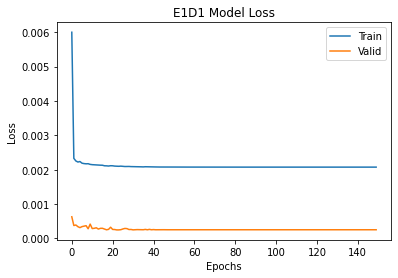

In [ ]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

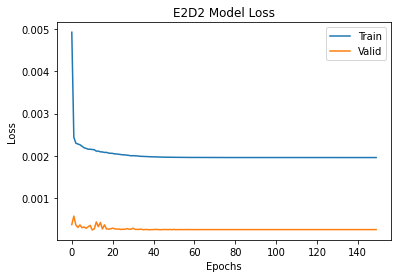

In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

In [ ]:
print(pred1_e1d1.shape)
print(pred1_e2d2.shape)

(1, 15, 5)
(1, 15, 5)


In [ ]:
for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])

    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
#print(y_test)
print(y_test.shape, pred1_e1d1.shape, pred1_e2d2.shape)
print(pred1_e2d2)
print(y_test)
print(pred1_e1d1)

(1, 15, 5) (1, 15, 5) (1, 15, 5)
[[[ 1.03179990e+04  2.08136346e-03 -5.42011745e-02 -1.54502526e-01
   -7.91091025e-02]
  [ 1.03179238e+04  9.05253226e-04 -3.56045626e-02 -1.48694620e-01
   -8.80037025e-02]
  [ 1.03178467e+04  6.51488372e-05 -2.55928375e-02 -1.46882981e-01
   -1.04869068e-01]
  [ 1.03179775e+04 -3.56600183e-04 -1.71770193e-02 -1.38936371e-01
   -1.18902065e-01]
  [ 1.03180928e+04 -4.25683218e-04 -1.13638118e-02 -1.27380624e-01
   -1.29943952e-01]
  [ 1.03181387e+04 -2.41749833e-04 -7.60653894e-03 -1.13544658e-01
   -1.37765214e-01]
  [ 1.03181143e+04  9.07662761e-05 -5.19280322e-03 -9.84444618e-02
   -1.42446801e-01]
  [ 1.03180391e+04  4.82840376e-04 -3.49568878e-03 -8.29017088e-02
   -1.44203052e-01]
  [ 1.03179346e+04  8.68248928e-04 -2.06419406e-03 -6.75956383e-02
   -1.43296346e-01]
  [ 1.03178203e+04  1.20375410e-03 -6.23962085e-04 -5.30773550e-02
   -1.40003458e-01]
  [ 1.03177139e+04  1.46569847e-03  9.55487543e-04 -3.97767983e-02
   -1.34608075e-01]
  [ 1.0317

In [ ]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(dataset_train.columns):
  print(i)
  for j in range(1,n_future+1):
    print("Day ",j,":")
    print(y_test[:, j-1, index])
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()

close
Day  1 :
[10316.22]
MAE-E1D1 :  2.203828125000655, MAE-E2D2 :  1.7790234375006548
Day  2 :
[10318.08]
MAE-E1D1 :  0.45906250000007276, MAE-E2D2 :  0.15617187499992724
Day  3 :
[10315.88]
MAE-E1D1 :  2.5575000000008004, MAE-E2D2 :  1.9666796875008004
Day  4 :
[10312.05]
MAE-E1D1 :  6.410937500000728, MAE-E2D2 :  5.927539062500728
Day  5 :
[10314.94]
MAE-E1D1 :  3.5824609374994907, MAE-E2D2 :  3.1527734374994907
Day  6 :
[10316.77]
MAE-E1D1 :  1.8061718750013824, MAE-E2D2 :  1.3686718750013824
Day  7 :
[10321.39]
MAE-E1D1 :  2.781601562499418, MAE-E2D2 :  3.275742187499418
Day  8 :
[10320.77]
MAE-E1D1 :  2.1528125000004366, MAE-E2D2 :  2.7309375000004366
Day  9 :
[10321.16]
MAE-E1D1 :  2.5467187499980355, MAE-E2D2 :  3.2254296874980355
Day  10 :
[10322.5]
MAE-E1D1 :  3.900390625, MAE-E2D2 :  4.6796875
Day  11 :
[10319.47]
MAE-E1D1 :  0.8830859374993452, MAE-E2D2 :  1.7561328124993452
Day  12 :
[10319.]
MAE-E1D1 :  0.4208984375, MAE-E2D2 :  1.373046875
Day  13 :
[10319.34]
MAE-E1D1 

Model e1d1 trainato per 5 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=3.8984375
Model e1d1 trainato per 10 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.3623046875
Model e1d1 trainato per 15 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.4443359375
Model e1d1 trainato per 20 epoche: 


Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=2.86328125
Model e1d1 trainato per 25 epoche: 


Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.06640625
Model e1d1 trainato per 30 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.52734375
Model e1d1 trainato per 35 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.5439453125
Model e1d1 trainato per 40 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.15625
Model e1d1 trainato per 45 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.138671875
Model e1d1 trainato per 50 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.275390625
Model e1d1 trainato per 55 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.1494140625
Model e1d1 trainato per 60 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.10546875
Model e1d1 trainato per 65 

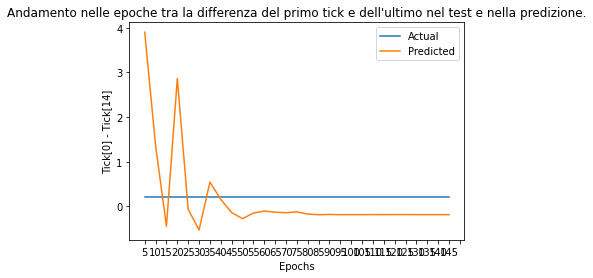

In [ ]:
import keras

history_actual = []
history_predicted = []

for j in range(5, 150, 5):
  print(f"Model e1d1 trainato per {j} epoche: ")
  model = keras.models.load_model(f"/content/e1d1_checkpoints/model{j:d}")
  pred = model.predict(X_test)
  for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])

  #print(y_test[:, 0, 0], y_test[:, 14, 0], pred[:, 0, 0], pred[:, 14, 0])
  print(f"Differenza tra primo e ultimo giorno::::: actual={y_test[:, 0, 0][0] - y_test[:, 14, 0][0]} <-> pred={pred[:, 0, 0][0] - pred[:, 14, 0][0]}")

  history_actual.append(y_test[:, 0, 0][0] - y_test[:, 14, 0][0])
  history_predicted.append(pred[:, 0, 0][0] - pred[:, 14, 0][0])

plt.xticks(np.arange(30), np.arange(5, 150, 5))
plt.plot(history_actual)
plt.plot(history_predicted)
plt.title("Andamento nelle epoche tra la differenza del primo tick e dell'ultimo nel test e nella predizione.")
plt.xlabel('Epochs')
plt.ylabel('Tick[0] - Tick[14]')
plt.legend(['Actual', 'Predicted'])
#plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams['figure.figsize'] = [120, 80]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

  # Adesso bisogna fare il confronto con i valori veri -y_test!
  #for j in range(1,n_future+1):
  #  diff = y_test[:, j-1, 0] - pred[:, j-1, 0] 
  #  print(f"Tick {j} -> actual={y_test[:, j-1, 0]} predicted={pred[:, j-1, 0]} ==> diff={diff}")

print()

In [ ]:
history_actual = []
history_predicted = []

for j in range(5, 150, 5):
  print(f"Model e2d2 trainato per {j} epoche: ")
  model = keras.models.load_model(f"/content/e2d2_checkpoints/model{j:d}")
  pred = model.predict(X_test)
  for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])

  #print(y_test[:, 0, 0], y_test[:, 14, 0], pred[:, 0, 0], pred[:, 14, 0])
  print(f"Differenza tra primo e ultimo giorno::::: actual={y_test[:, 0, 0][0] - y_test[:, 14, 0][0]} <-> pred={pred[:, 0, 0][0] - pred[:, 14, 0][0]}")

  history_actual.append(y_test[:, 0, 0][0] - y_test[:, 14, 0][0])
  history_predicted.append(pred[:, 0, 0][0] - pred[:, 14, 0][0])

plt.xticks(np.arange(30), np.arange(5, 150, 5))
plt.plot(history_actual)
plt.plot(history_predicted)
plt.title("Andamento nelle epoche tra la differenza del primo tick e dell'ultimo nel test e nella predizione.")
plt.xlabel('Epochs')
plt.ylabel('Tick[0] - Tick[14]')
plt.legend(['Actual', 'Predicted'])
#plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams['figure.figsize'] = [60, 40]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

  # Adesso bisogna fare il confronto con i valori veri -y_test!
  #for j in range(1,n_future+1):
  #  diff = y_test[:, j-1, 0] - pred[:, j-1, 0] 
  #  print(f"Tick {j} -> actual={y_test[:, j-1, 0]} predicted={pred[:, j-1, 0]} ==> diff={diff}")

print()

Model e2d2 trainato per 5 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=4.7470703125
Model e2d2 trainato per 10 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-1.12890625
Model e2d2 trainato per 15 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.958984375
Model e2d2 trainato per 20 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-3.208984375
Model e2d2 trainato per 25 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.630859375
Model e2d2 trainato per 30 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.1376953125
Model e2d2 trainato per 35 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.5654296875
Model e2d2 trainato per 40 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=